# 2 Regression

In [3]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
class HousingDataset(Dataset):    
    def __init__(self, df):
        self.dataframe = df
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = np.asarray(self.dataframe.iloc[idx])
        x = torch.tensor(sample[:-1])
        label = torch.tensor(sample[-1])
            
        return x.float(), label.float()
        

In [7]:
def get_data(df, batch_size):   
    scaler = StandardScaler()
    scaler.fit(df)
    data = scaler.transform(df)
    data = pd.DataFrame(data, columns = df.columns)
    
    train_size = 0.8
    valid_size = 0.1
    test_size = 0.1

    split_one = int(len(data)*train_size)
    split_two = split_one + int(len(data)*valid_size)

    train_data = data[:split_one]
    valid_data = data[split_one:split_two]
    test_data = data[split_two:]
    
    train_dataset = HousingDataset(train_data)
    valid_dataset = HousingDataset(valid_data)
    test_dataset = HousingDataset(test_data)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
    
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    
    return train_dataloader, valid_dataloader, test_dataloader

In [8]:
def validate(valid_dataloader, loss_criterion, net):
    valid_loss = np.zeros(len(valid_dataloader))
    
    net.eval()
    for i_batch, valid_batch in enumerate(valid_dataloader):
        x, y = valid_batch
        y = torch.reshape(y, (y.shape[0], 1))
        predictions = net(x)
        batch_loss = loss_criterion(predictions, y)
        valid_loss[i_batch] = batch_loss.item()
    
    return np.mean(valid_loss) # Mean loss for each batch from the validation set

In [9]:
def train_net(net, train_dataloader,valid_dataloader, lr = 0.0001, n_epochs = 30, loss_criterion = nn.MSELoss()):
    torch.manual_seed(0)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    valid_losses = []
    train_losses = []
    
    best_loss = None
    epochs_since_improvement = 0
    
    for epoch in range(n_epochs):
        if epochs_since_improvement == 3:
            print(f'\nTraining stopped at epoch {epoch}, Training loss: {mean_training_loss}, Validation loss : {mean_validation_loss}')
            break
            
        net.train()
        epoch_training_loss = np.zeros(len(train_dataloader))
        
        # Training
        for i_batch, train_batch in enumerate(train_dataloader):
            x, y = train_batch
            
            y = torch.reshape(y, (y.shape[0], 1))
            predictions = net(x)

            loss = loss_criterion(predictions, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_training_loss[i_batch] = loss.item()
        
        mean_training_loss = np.mean(epoch_training_loss) # Mean loss for each batch from the training set
        train_losses.append(mean_training_loss)
        
        # Validation
        mean_validation_loss = validate(valid_dataloader, loss_criterion, net)
        valid_losses.append(mean_validation_loss)
        
        if best_loss == None:
            best_loss = mean_validation_loss
            
        if mean_validation_loss < best_loss:
            torch.save(net.state_dict(), 'best_model.pt')
            best_loss = mean_validation_loss
            epochs_since_improvement = 0
        
        else:
            epochs_since_improvement += 1
        
        print(f'Epoch {epoch+1} / {n_epochs} valid loss: {mean_validation_loss}, train loss: {mean_training_loss}')
    
    return net, valid_losses, train_losses


In [10]:
df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names= ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])

torch.manual_seed(0)

train_dataloader, valid_dataloader, test_dataloader = get_data(df, batch_size = 8)

print(f'Train DataLoader:\nLength: {len(train_dataloader.dataset)}\nBatchsize: {train_dataloader.batch_size}\n-')
print(f'Validation DataLoader:\nLength: {len(valid_dataloader.dataset)}\nBatchsize: {valid_dataloader.batch_size}\n-')
print(f'Test DataLoader:\nLength: {len(test_dataloader.dataset)}\nBatchsize: {test_dataloader.batch_size}\n{"-"*10}')

net = nn.Sequential(nn.Linear(13,32), nn.ReLU(),
                    nn.Linear(32,16), nn.ReLU(), nn.Dropout(0.1),
                    nn.Linear(16,1)).float()

net, valid_losses, train_losses = train_net(net, 
                train_dataloader,
                valid_dataloader,
                lr = 0.0001, 
                n_epochs = 30, 
                loss_criterion = nn.MSELoss())


Train DataLoader:
Length: 404
Batchsize: 8
-
Validation DataLoader:
Length: 50
Batchsize: 8
-
Test DataLoader:
Length: 52
Batchsize: 8
----------
Epoch 1 / 30 valid loss: 1.6318151269640242, train loss: 1.0022788032451098
Epoch 2 / 30 valid loss: 1.2426147375788008, train loss: 0.9621129503437117
Epoch 3 / 30 valid loss: 1.1751511352402824, train loss: 0.9290270079292503
Epoch 4 / 30 valid loss: 1.0739237240382604, train loss: 0.919092598791216
Epoch 5 / 30 valid loss: 0.9661008034433637, train loss: 0.8709338374581992
Epoch 6 / 30 valid loss: 0.8042305282184056, train loss: 0.838198151658563
Epoch 7 / 30 valid loss: 0.7579970700400216, train loss: 0.7966785740618613
Epoch 8 / 30 valid loss: 0.6593947325434003, train loss: 0.7837459579402325
Epoch 9 / 30 valid loss: 0.5782370907919747, train loss: 0.7543381996014539
Epoch 10 / 30 valid loss: 0.565093742949622, train loss: 0.7146908412961399
Epoch 11 / 30 valid loss: 0.44881742341177805, train loss: 0.6696766441797509
Epoch 12 / 30 vali

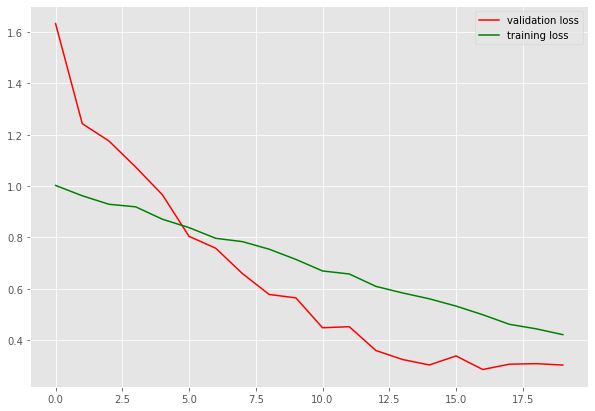

In [12]:
plt.figure(figsize = (10,7))
plt.plot([i for i in range(len(valid_losses))], list(valid_losses), c = 'red', label = 'validation loss')
plt.plot([i for i in range(len(train_losses))], list(train_losses), c = 'green', label = 'training loss')
plt.legend()
plt.show()


In [13]:
def load_model(path):
    # Här sätter vi ett tomt nät med samma arkitektur som vi sedan laddar med dem sparade parametrarna
    model = nn.Sequential(nn.Linear(13,32), nn.ReLU(),
                        nn.Linear(32,16), nn.ReLU(),nn.Dropout(),
                        nn.Linear(16,1)).float()
    
    model.load_state_dict(torch.load(path))
    return model

In [14]:
model = load_model('best_model.pt')

In [15]:
predictions = []
ys = []

for i_batch, batch in enumerate(test_dataloader):
    x, y = batch

    y = torch.reshape(y, (y.shape[0],1))

    model.eval()

    with torch.no_grad():
        prediction = model(x)
        
    predictions.extend(prediction)
    ys.extend(y)
    
y = [t.item() for t in ys]
predictions = [t.item() for t in predictions]

R2:  0.4508264211061157
MSE:  0.1224981183801892
MAE:  0.26304857124789405
MAPE:  0.8743406124971942


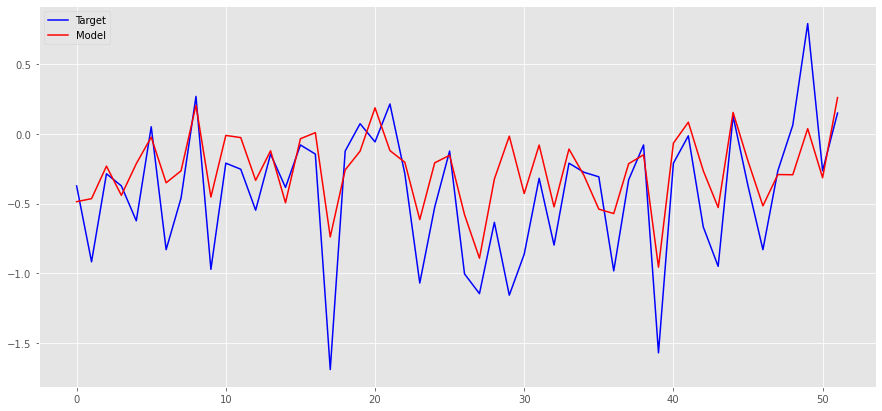

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

r2_score = r2(y, predictions)
mse_score = mse(y, predictions)
mae_score = mae(y, predictions)
mape_score = mape(y, predictions)

print('R2: ', r2_score)
print('MSE: ', mse_score)
print('MAE: ', mae_score)
print('MAPE: ', mape_score)

plt.figure(figsize = (15,7))
plt.plot([i for i in range(len(predictions))], y, c = 'blue', label = 'Target')
plt.plot([i for i in range(len(predictions))], predictions, c = 'red', label = 'Model')
plt.legend()

plt.show()

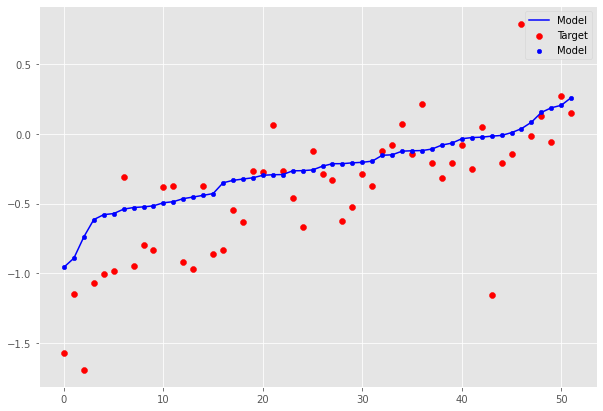

In [17]:
zipped = list(zip(y, predictions))
sorted_ = list(sorted(zipped, key = lambda x: x[1]))

plt.figure(figsize = (10,7))
plt.scatter([i for i in range(len(sorted_))],[i[0] for i in sorted_], label = 'Target', c = 'Red')
plt.plot([i for i in range(len(sorted_))],[i[1] for i in sorted_], label = 'Model', c = 'Blue')
plt.scatter([i for i in range(len(sorted_))],[i[1] for i in sorted_], label = 'Model', c = 'Blue', s = 20)

plt.legend()
plt.show()